## Predicting Crime in Los Angeles
Capstone 1 Project - Step 3: Exploratory Data Analysis

Notebook by Oliver Bohler

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import optuna
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap


pd.options.display.max_columns = 400
pd.options.display.max_rows = 400

crimes = '/Users/oliverbohler/Desktop/Springboard/capstone project 2 violent crime in los angeles/Crime_LA_2010_2023.csv'
crime = pd.read_csv(crimes)
crime.head()

,Date Occured,Time Occured,Area Name,Zone,Crime Code,year,month,day,Weekday,Crime Code Description,Vict Age,Crime Category,Vict Sex,Vict Descent,Premis Code,Premis Group,Premis Desc,Weapon Category,Weapon Used Cd,Weapon Desc,Status,Status Desc,Location,Lat,Lon
0,2010-01-02,21:00,Central,Hollywood/Greater Downtown Area,122,2010,1,2,Saturday,"RAPE, ATTEMPTED",47.0,Sexual Offenses,F,H,103.0,Street/Outdoor,ALLEY,Strong-Arm,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,8TH ST,34.0387,-118.2488
1,2010-01-08,21:00,Central,Hollywood/Greater Downtown Area,230,2010,1,8,Friday,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",51.0,Assault & Battery,M,B,710.0,Other Premise,OTHER PREMISE,Other Object,500,UNKNOWN WEAPON/OTHER WEAPON,AA,Adult Arrest,500 CROCKER ST,34.0435,-118.2427
2,2010-01-09,02:30,Central,Hollywood/Greater Downtown Area,230,2010,1,9,Saturday,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",30.0,Assault & Battery,M,H,108.0,Street/Outdoor,PARKING LOT,Strong-Arm,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,800 W OLYMPIC BL,34.0450,-118.2640
3,2010-01-14,14:45,Central,Hollywood/Greater Downtown Area,624,2010,1,14,Thursday,BATTERY - SIMPLE ASSAULT,38.0,Assault & Battery,F,B,101.0,Street/Outdoor,STREET,Strong-Arm,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,900 N BROADWAY,34.0640,-118.2375
4,2010-01-14,20:00,Central,Hollywood/Greater Downtown Area,210,2010,1,14,Thursday,ROBBERY,40.0,Robbery & Burglary,M,H,101.0,Street/Outdoor,STREET,Strong-Arm,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,ALAMEDA ST,34.0350,-118.2386


# Data Preprocessing for Crime Dataset

This section outlines the preprocessing steps taken to prepare the dataset for modeling, building upon the exploratory data analysis (EDA) findings. The focus is on addressing the challenges of class imbalance and irrelevant features while aligning the target variable (`Status Desc`) with meaningful categories.

---

## Target Variable Transformation
The `Status Desc` column, representing the status of incidents, was refined based on the EDA findings:
- Categories such as `Juv Arrest`, `Juv Other`, and `UNK` were removed due to their minimal representation in the dataset.
- The remaining statuses (`Adult Arrest`, `Adult Other`) were encoded as `1` (arrest) to represent the minority class, while all other statuses were encoded as `0` (no arrest).

These transformations address the class imbalance identified during the EDA, where the majority class ("No Arrest") dominated the dataset. This ensures the model focuses on distinguishing arrests from non-arrests.

---

## Feature Engineering
1. **Victim Age Adjustment:**
   - To handle potential inconsistencies in the `Vict Age` column, values were scaled using a logarithmic transformation: `Vict Age = 5 * np.round(1 / 5 * x)`. This creates age bins, smoothing extreme values and improving interpretability.

2. **Feature Selection:**
   - Irrelevant columns, including descriptive or redundant data such as `Crime Code`, `Date Occured`, `Premis Code`, and `Location`, were dropped to reduce noise in the dataset.
   - This step is informed by the EDA, which identified minimal contributions of these columns to meaningful patterns in the data.

3. **One-Hot Encoding:**
   - Categorical features were encoded using one-hot encoding to convert them into a format suitable for machine learning models.

---

## Data Normalization
Using `StandardScaler`, numerical features were scaled to have zero mean and unit variance. This step is critical to ensure that features are on comparable scales, especially for distance-based algorithms.

---

## Dataset Splitting
The dataset was split into training and test sets using stratified sampling to preserve the proportion of the target classes (`Arrest` vs. `No Arrest`). This ensures a balanced representation of both classes in the training and test datasets.

---

## Class Imbalance Handling
To address the class imbalance highlighted during the EDA:
- **Class Weights:** Class weights were computed to penalize misclassifications of the minority class (`1: Arrest`). These weights ensure the model does not overly favor the majority class (`0: No Arrest`).

---

## Summary
These preprocessing steps ensure that the dataset is clean, representative, and appropriately structured for machine learning. By addressing the class imbalance, irrelevant features, and scaling, the prepared dataset aligns with the EDA findings and supports the creation of a robust predictive model for crime outcomes. The next steps involve selecting and tuning machine learning models to accurately predict arrest statuses while mitigating bias toward the majority class.

In [2]:
print(type(crime))

<class 'pandas.core.frame.DataFrame'>


In [3]:
crime['Status Desc'].value_counts()

Status Desc
Invest Cont     447698
Adult Other     194436
Adult Arrest    139635
Juv Arrest        9367
Juv Other         3953
UNK                  7
Name: count, dtype: int64

In [4]:
main_label = 'Status Desc'
remove_status = ['Juv Arrest', 'Juv Other', 'UNK']

crime = crime[~crime[main_label].isin(remove_status)]

crime[main_label] = crime[main_label].apply(lambda x: 1 if x in ['Adult Arrest', 'Adult Other'] else 0).astype(int)

crime['Vict Age'] = crime['Vict Age'].apply(lambda x: 5 * round(1 / 5 * x))

cols2drop = ['Crime Code', 'Date Occured', 'Weekday', 'Area Name', 'Time Occured', 'Crime Code Description',
             'Premis Code', 'Premis Desc', 'Weapon Used Cd', "Weapon Desc", 'Status',
             'Location', 'Lat', 'Lon']

crime = crime.drop(cols2drop, axis=1)

y = crime[main_label].values.reshape(-1,)
X = crime.drop([main_label], axis=1)

cat_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, stratify=y)


In [5]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)

{0: 0.8730993025424534, 1: 1.1700628982589791}


# Random Forest Model: Results and Evaluation

This section summarizes the implementation and evaluation of a **Random Forest Classifier** to predict arrest statuses. The steps include training the model, making predictions, and evaluating performance using metrics such as accuracy, ROC AUC, precision, recall, and the confusion matrix.

---

## Model Implementation
- The **RandomForestClassifier** was initialized with:
  - `n_estimators=100`: 100 decision trees in the forest.
  - `random_state=42`: Ensures reproducibility.
  - `class_weight='balanced'`: Adjusts weights inversely proportional to class frequencies to address class imbalance.
- The model was trained on the processed training dataset (`X_train`, `y_train`) and evaluated on the test dataset (`X_test`, `y_test`).

---

In [6]:
model = RandomForestClassifier(n_estimators = 100, random_state=42, class_weight = class_weights)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)


y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.65
ROC AUC score: 0.6902
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71     89540
           1       0.60      0.53      0.56     66814

    accuracy                           0.65    156354
   macro avg       0.64      0.64      0.64    156354
weighted avg       0.65      0.65      0.65    156354

Confusion Matrix:
[[66410 23130]
 [31439 35375]]


## Key Observations
- The model performs slightly better at predicting the majority class (`No Arrest`) than the minority class (`Arrest`), as evidenced by higher recall and precision for Class 0.
- The **class imbalance** in the dataset likely impacts the model's performance, as the recall for Class 1 is relatively low at 53%. This suggests that many actual arrests were misclassified as "No Arrest."
- While the ROC AUC score of 0.69 indicates moderate separability, there is room for improvement, particularly in boosting the model's sensitivity toward the minority class.

---

## Next Steps
1. **Improving Recall for Class 1**:
- Experiment with hyperparameter tuning for the Random Forest model to enhance performance.
- Consider alternative models like XGBoost or logistic regression with class-weight adjustments.
2. **Addressing Class Imbalance**:
- Employ advanced resampling techniques such as **SMOTE** to balance the training dataset further.

# Addressing Class Imbalance Using SMOTE

## SMOTE (Synthetic Minority Oversampling Technique)
Class imbalance, as identified during exploratory data analysis, posed a challenge for predicting arrest statuses accurately. The majority class (`No Arrest`) significantly outnumbered the minority class (`Arrest`), which could lead to biased model predictions. To address this issue, **SMOTE** was applied to oversample the minority class in the training dataset.

SMOTE generates synthetic samples for the minority class by interpolating between existing samples and their nearest neighbors. This technique ensures a balanced representation of both classes in the training data without simply duplicating existing records, thus preserving variability in the dataset.

---

In [7]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled training set shape: {X_train_res.shape}, {y_train_res.shape}")

Original training set shape: (625415, 22), (625415,)
Resampled training set shape: (716316, 22), (716316,)


In [8]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

model.fit(X_train_res, y_train_res)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Accuracy: 0.67
ROC AUC score: 0.7289
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71     89540
           1       0.61      0.62      0.62     66814

    accuracy                           0.67    156354
   macro avg       0.66      0.67      0.66    156354
weighted avg       0.67      0.67      0.67    156354

Confusion Matrix:
[[63593 25947]
 [25402 41412]]


### Model Evaluation
Using the resampled dataset, a **Random Forest Classifier** was trained with the following parameters:
- `n_estimators=100`: Number of trees in the forest.
- `max_depth=10`: Maximum depth of the trees to prevent overfitting.
- `random_state=42`: Ensures reproducibility.

The model was evaluated on the test set, and the results are summarized below:

1. **Accuracy**:  
   - The model achieved an accuracy of **67%**, reflecting a slight improvement from the pre-SMOTE model (65%).

2. **ROC AUC Score**:  
   - The ROC AUC score increased to **0.7289**, indicating better separability between the two classes compared to the pre-SMOTE score of 0.6902.

3. **Classification Report**:  
   - **Class 0 (No Arrest)**:
     - Precision: 71%
     - Recall: 71%
     - F1-Score: 71%
   - **Class 1 (Arrest)**:
     - Precision: 61%
     - Recall: 62%
     - F1-Score: 62%
   - The macro-average F1-score and weighted-average F1-score both improved to 66% and 67%, respectively.

4. **Confusion Matrix**:  
   - The confusion matrix showed:
     ```
     [[63593 25947]  # Class 0: True Negatives and False Positives
      [25402 41412]] # Class 1: False Negatives and True Positives
     ```
   - This indicates an increase in the model's ability to correctly predict the minority class (`Arrest`), with fewer false negatives compared to the pre-SMOTE model.

---

### Key Insights
1. **Improved Minority Class Performance**:  
   The application of SMOTE increased the recall for the minority class (`Arrest`) from 53% to 62%, demonstrating the effectiveness of oversampling in reducing the bias toward the majority class.
   
2. **Better Model Balance**:  
   The increase in both the ROC AUC score and F1-scores indicates that the model is better balanced in its predictions for both classes.

3. **Trade-off**:  
   While precision for the minority class remained lower at 61%, the improved recall ensures that more arrests are correctly identified, which is often critical in applications involving sensitive outcomes.

---

### Conclusion
By applying SMOTE, the model significantly reduced the impact of class imbalance, leading to improved performance for the minority class (`Arrest`) and a more balanced overall predictive capability. Further enhancements can be explored through hyperparameter tuning and experimenting with alternative oversampling techniques.







# Hyperparameter Optimization and Evaluation of Random Forest Model

This section highlights the process of optimizing a Random Forest model using **Optuna**, the challenges encountered during the optimization process, and an evaluation of the final model performance.

---

## Hyperparameter Optimization with Optuna
To enhance the performance of the Random Forest model, **Optuna** was employed to conduct hyperparameter tuning. The objective function was defined to maximize the **ROC AUC score**, a metric chosen for its suitability in handling imbalanced datasets.

### Hyperparameters Tuned
- `n_estimators`: Number of trees in the forest (range: 100-500).
- `max_depth`: Maximum depth of each tree (range: 5-30).
- `min_samples_split`: Minimum samples required to split a node (range: 2-20).
- `min_samples_leaf`: Minimum samples required to form a leaf node (range: 1-10).
- `max_features`: Number of features to consider when looking for the best split (`sqrt`, `log2`, or all features).
- `class_weight`: Weighting of classes (`balanced`, `balanced_subsample`, or none).
- `bootstrap`: Whether to use bootstrap samples (`True` or `False`).

The hyperparameter search involved integrating **SMOTE** into a pipeline to ensure that the minority class was adequately represented during cross-validation.

### Challenges with Optimization
The optimization process involved running **25 trials**, each with cross-validation over 3 folds. This approach, while thorough, was computationally intensive and time-consuming due to:
1. The large dataset size after applying SMOTE.
2. The high number of hyperparameters being tuned.
3. The complexity of the Random Forest model, especially with deeper trees and higher numbers of estimators.

---

In [27]:
from imblearn.pipeline import Pipeline
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        bootstrap=bootstrap,
        random_state=0
    )
    
    # Create a pipeline with SMOTE and the model
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    #cross-validation with SMOTE
    roc_auc = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return roc_auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  

print("Best parameters found: ", study.best_params)
print("Best ROC AUC score: ", study.best_value)


[I 2024-09-03 10:42:24,737] A new study created in memory with name: no-name-6eb401f6-9f9d-49cd-9604-b73a8d7163c0
[I 2024-09-03 10:50:19,595] Trial 0 finished with value: 0.7231776697895226 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': None, 'bootstrap': False}. Best is trial 0 with value: 0.7231776697895226.
[I 2024-09-03 11:19:06,777] Trial 1 finished with value: 0.726820742207512 and parameters: {'n_estimators': 233, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'bootstrap': True}. Best is trial 1 with value: 0.726820742207512.
[I 2024-09-03 11:34:32,202] Trial 2 finished with value: 0.7129814966852782 and parameters: {'n_estimators': 146, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced_subsample', 'bootstrap': False}. Best is trial 1 with value: 0.7268207422

Best parameters found:  {'n_estimators': 498, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': None, 'bootstrap': True}
Best ROC AUC score:  0.7341695758517015


In [28]:
best_params = study.best_params

model = RandomForestClassifier(**best_params, random_state=0)
model.fit(X_train_res, y_train_res)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

roc_auc_test = roc_auc_score(y_test, y_test_prob)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Test ROC AUC score: {roc_auc_test:.4f}")
print(f"Accuracy: {accuracy_test:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Test ROC AUC score: 0.7367
Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72     89540
           1       0.62      0.63      0.63     66814

    accuracy                           0.68    156354
   macro avg       0.67      0.67      0.67    156354
weighted avg       0.68      0.68      0.68    156354

Confusion Matrix:
[[63502 26038]
 [24391 42423]]


## Evaluation of the Final Random Forest Model
Using the best hyperparameters, the Random Forest model was trained on the resampled dataset (with SMOTE applied) and evaluated on the test set. Below are the results:

### Test Set Performance
1. **ROC AUC Score**:  
   - The model achieved a ROC AUC score of **0.7367**, indicating good separability between the two classes (`Arrest` and `No Arrest`).

2. **Accuracy**:  
   - The accuracy was **68%**, reflecting an improvement over the initial model trained without optimization or SMOTE.

3. **Classification Report**:
   - **Class 0 (No Arrest)**:
     - Precision: 72%
     - Recall: 71%
     - F1-Score: 72%
   - **Class 1 (Arrest)**:
     - Precision: 62%
     - Recall: 63%
     - F1-Score: 63%
   - Both macro-average and weighted-average F1-scores were **67%**, highlighting balanced performance across both classes.


# XGBoost Model: Training and Evaluation

This section presents the implementation of the **XGBoost Classifier** on the crime dataset and compares its performance to the previously optimized Random Forest model.

---

## XGBoost Model Implementation
The XGBoost model was configured with the following hyperparameters:
- `objective='binary:logistic'`: Optimized for binary classification.
- `n_estimators=100`: The number of boosting rounds.
- `max_depth=6`: The maximum depth of each tree to control overfitting.
- `learning_rate=0.1`: Step size shrinkage to prevent overfitting.
- `subsample=0.8`: Fraction of the training data used for each boosting round.
- `colsample_bytree=0.8`: Fraction of features used for constructing each tree.
- `random_state=42`: Ensures reproducibility.

The model was trained on the resampled dataset (using SMOTE) and evaluated on the test set.

---

In [9]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train_res, y_train_res)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Accuracy: 0.68
ROC AUC score: 0.7341
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73     89540
           1       0.63      0.59      0.61     66814

    accuracy                           0.68    156354
   macro avg       0.67      0.67      0.67    156354
weighted avg       0.68      0.68      0.68    156354

Confusion Matrix:
[[66796 22744]
 [27429 39385]]


## Evaluation of XGBoost Model
### Test Set Performance
1. **ROC AUC Score**:  
   - The XGBoost model achieved a ROC AUC score of **0.7341**, comparable to the optimized Random Forest model's score of **0.7367**.

2. **Accuracy**:  
   - The accuracy was **68%**, identical to the optimized Random Forest model.

3. **Classification Report**:
   - **Class 0 (No Arrest)**:
     - Precision: 71%
     - Recall: 75%
     - F1-Score: 73%
   - **Class 1 (Arrest)**:
     - Precision: 63%
     - Recall: 59%
     - F1-Score: 61%
   - Macro-average and weighted-average F1-scores were both **67%**, consistent with the Random Forest model.


- Compared to the Random Forest, XGBoost had slightly higher recall for Class 0 but lower recall for Class 1.

---

## Comparison with Random Forest
| Metric                 | Random Forest       | XGBoost            |
|------------------------|---------------------|---------------------|
| **ROC AUC Score**      | 0.7367             | 0.7341             |
| **Accuracy**           | 68%                | 68%                |
| **Class 0 Precision**  | 72%                | 71%                |
| **Class 0 Recall**     | 71%                | 75%                |
| **Class 1 Precision**  | 62%                | 63%                |
| **Class 1 Recall**     | 63%                | 59%                |
| **Class 1 F1-Score**   | 63%                | 61%                |

### Key Observations:
1. **ROC AUC and Accuracy**:
- Both models achieved nearly identical ROC AUC scores and accuracy, indicating comparable overall performance.

2. **Class 0 vs. Class 1 Performance**:
- XGBoost performed better for **Class 0 (No Arrest)**, achieving higher recall, meaning it correctly identified more instances of this majority class.
- Random Forest performed better for **Class 1 (Arrest)**, achieving higher recall and F1-score, which is critical given the minority class's importance.

3. **Efficiency**:
- XGBoost is known for faster computation and scalability, potentially making it more efficient for larger datasets or more iterations.

---

## Conclusion
Both models demonstrate strong performance on the dataset, with slight trade-offs in class-specific metrics:
- **Random Forest** is preferred for tasks prioritizing the minority class (`Arrest`), given its higher recall and F1-score for this class.
- **XGBoost** is preferred for tasks requiring better identification of the majority class (`No Arrest`) or for scenarios requiring faster training.

## Hyperparameter Optimization for XGBoost
Using **Optuna**, the following hyperparameters were optimized:
- `n_estimators`: Number of boosting rounds (100-1000).
- `max_depth`: Maximum tree depth (3-10).
- `learning_rate`: Step size shrinkage (0.01-0.3).
- `subsample`: Fraction of training samples for each boosting round (0.5-1.0).
- `colsample_bytree`: Fraction of features used for each tree (0.5-1.0).
- `gamma`: Minimum loss reduction for splitting (1e-8-1.0).
- `reg_alpha`: L1 regularization (1e-8-1.0).
- `reg_lambda`: L2 regularization (1e-8-1.0).

### Best Hyperparameters Found
After 25 trials, the following hyperparameters achieved the best **AUC score**:
- `n_estimators`: 663
- `max_depth`: 10
- `learning_rate`: 0.016
- `subsample`: 0.802
- `colsample_bytree`: 0.902
- `gamma`: 1.739e-5
- `reg_alpha`: 0.009
- `reg_lambda`: 0.00022

The best **cross-validated AUC score** was **0.7414**.

---


In [21]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 regularization
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**param)
    
    auc = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring='roc_auc').mean()
    
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  

print("Best parameters found: ", study.best_params)
print("Best AUC score: ", study.best_value)


best_params = study.best_params
model = xgb.XGBClassifier(**best_params)
model.fit(X_train_res, y_train_res)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test ROC AUC score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


[I 2024-09-10 20:38:51,232] A new study created in memory with name: no-name-f5a41e1f-c726-48ad-869f-3b38cd662a08
[I 2024-09-10 20:38:58,665] Trial 0 finished with value: 0.7324929534518883 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.25926556112308374, 'subsample': 0.6600077004687297, 'colsample_bytree': 0.9907570265516501, 'gamma': 5.335505822013044e-07, 'reg_alpha': 2.5821865513815226e-08, 'reg_lambda': 0.22290012219987856}. Best is trial 0 with value: 0.7324929534518883.
[I 2024-09-10 20:39:17,205] Trial 1 finished with value: 0.7348526927040133 and parameters: {'n_estimators': 413, 'max_depth': 4, 'learning_rate': 0.08583829329672381, 'subsample': 0.8597065527876333, 'colsample_bytree': 0.6856819866006979, 'gamma': 1.134182220924683e-08, 'reg_alpha': 0.46955281911968744, 'reg_lambda': 0.0366477075615373}. Best is trial 1 with value: 0.7348526927040133.
[I 2024-09-10 20:39:38,196] Trial 2 finished with value: 0.7311968891515943 and parameters: {'n_estima

[I 2024-09-10 20:54:37,659] Trial 21 finished with value: 0.7407384218931533 and parameters: {'n_estimators': 821, 'max_depth': 9, 'learning_rate': 0.03427937148552038, 'subsample': 0.8451253195540589, 'colsample_bytree': 0.9003442752525114, 'gamma': 4.520883719095356e-05, 'reg_alpha': 0.003170923797492756, 'reg_lambda': 0.0035658724174299395}. Best is trial 8 with value: 0.7413322185961513.
[I 2024-09-10 20:55:50,401] Trial 22 finished with value: 0.7406374886193721 and parameters: {'n_estimators': 997, 'max_depth': 9, 'learning_rate': 0.03286500277755267, 'subsample': 0.842433790708494, 'colsample_bytree': 0.8270249943947705, 'gamma': 0.00029609427233910944, 'reg_alpha': 0.0037338534224922266, 'reg_lambda': 0.0050279495813757525}. Best is trial 8 with value: 0.7413322185961513.
[I 2024-09-10 20:56:49,328] Trial 23 finished with value: 0.7414324363839878 and parameters: {'n_estimators': 663, 'max_depth': 10, 'learning_rate': 0.016170861660933532, 'subsample': 0.8025385053580214, 'cols

Best parameters found:  {'n_estimators': 663, 'max_depth': 10, 'learning_rate': 0.016170861660933532, 'subsample': 0.8025385053580214, 'colsample_bytree': 0.9021335700860794, 'gamma': 1.7390827381805827e-05, 'reg_alpha': 0.00983429097064532, 'reg_lambda': 0.00022153871173668163}
Best AUC score:  0.7414324363839878
Test Accuracy: 0.68
Test ROC AUC score: 0.7375
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73     89540
           1       0.64      0.57      0.61     66814

    accuracy                           0.68    156354
   macro avg       0.67      0.67      0.67    156354
weighted avg       0.68      0.68      0.68    156354

Confusion Matrix:
[[68390 21150]
 [28519 38295]]


## Evaluation of Optimized XGBoost
Using the best parameters, the optimized XGBoost model was evaluated on the test set:

### Test Set Performance
1. **ROC AUC Score**:  
   - The optimized XGBoost achieved a **ROC AUC score of 0.7375**, slightly outperforming the previous XGBoost model (0.7341) and comparable to the Random Forest model (0.7367).

2. **Accuracy**:  
   - The accuracy remained consistent at **68%**.

3. **Classification Report**:
   - **Class 0 (No Arrest)**:
     - Precision: 71%
     - Recall: 76%
     - F1-Score: 73%
   - **Class 1 (Arrest)**:
     - Precision: 64%
     - Recall: 57%
     - F1-Score: 61%
   - The macro-average and weighted-average F1-scores were both **67%**.
---

## Comparison of Models
| Metric                 | Random Forest       | Default XGBoost     | Optimized XGBoost |
|------------------------|---------------------|---------------------|-------------------|
| **ROC AUC Score**      | 0.7367             | 0.7341             | **0.7375**       |
| **Accuracy**           | 68%                | 68%                | 68%              |
| **Class 0 Precision**  | 72%                | 71%                | 71%              |
| **Class 0 Recall**     | 71%                | 75%                | **76%**          |
| **Class 1 Precision**  | 62%                | 63%                | **64%**          |
| **Class 1 Recall**     | **63%**            | 59%                | 57%              |
| **Class 1 F1-Score**   | **63%**            | 61%                | 61%              |

---

## Key Observations
1. **Overall Performance**:
- The optimized XGBoost model achieved the highest ROC AUC score (0.7375), marginally surpassing the Random Forest model.
- Accuracy across all models remained constant at 68%, indicating stable overall performance.

2. **Class-Specific Metrics**:
- **Class 0 (No Arrest)**:
  - The optimized XGBoost improved recall (76%) compared to both Random Forest (71%) and the default XGBoost (75%), making it more effective at correctly identifying the majority class.
- **Class 1 (Arrest)**:
  - The Random Forest performed better in recall (63%), highlighting its strength in detecting the minority class.
  - The optimized XGBoost achieved the highest precision (64%), reducing false positives for Class 1.

3. **Trade-offs**:
- The optimized XGBoost provides better balance for majority class detection but sacrifices some recall for the minority class, suggesting a slight trade-off in sensitivity.

---

## Conclusion
The optimized XGBoost model offers a marginal improvement in ROC AUC score while maintaining comparable accuracy. Its improved precision for the minority class (`Arrest`) and higher recall for the majority class (`No Arrest`) make it a strong contender, particularly for scenarios prioritizing precision over recall in minority class detection. However, for tasks requiring higher recall for arrests, the Random Forest model remains a viable choice. Future work could explore ensemble methods to combine the strengths of both models.








# Feature Importance Analysis

This section highlights the **feature importance** as determined by the model, providing insights into which features contributed most to predicting arrest statuses. Understanding feature importance is crucial for interpreting the model and identifying key factors influencing predictions.

---
## Observations
1. **Premis Group_Residential** is the most important feature, with an importance score of 0.247769, significantly higher than the other features. This suggests that crimes occurring in residential premises play a major role in predicting arrests.
2. **Premis Group_Street/Outdoor** is the second most important feature, indicating that outdoor crime locations are also a critical factor.
3. **Crime Category_Robbery & Burglary** ranks third, showing that specific types of crimes strongly influence arrest predictions.
4. Temporal features like **Month** and **Year** contribute meaningfully, suggesting seasonal or temporal patterns in crime data.
5. **Zones** such as **South LA** and **San Fernando Valley** are important, highlighting geographic trends in crime and arrest data.
6. Specific categories like **Crime Category_Theft** and **Weapon Category_Other Object** indicate that the nature of the crime and the weapon involved also affect prediction outcomes.

---

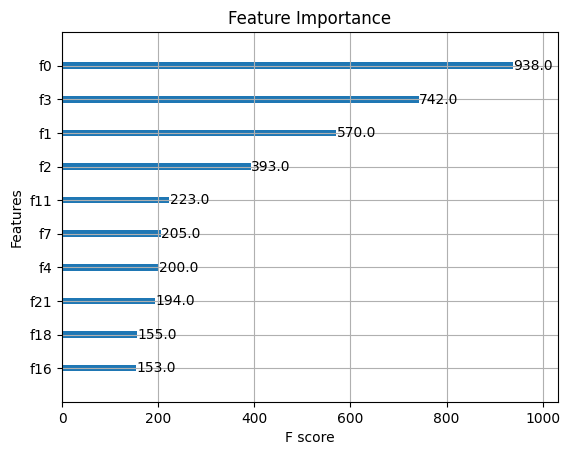

In [10]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10)  
plt.title('Feature Importance')
plt.show()

In [11]:
importances = model.feature_importances_
feature_names = X_encoded.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

                                    Feature  Importance
16                 Premis Group_Residential    0.247769
18              Premis Group_Street/Outdoor    0.140458
7         Crime Category_Robbery & Burglary    0.116173
1                                     month    0.061584
5                             Zone_South LA    0.057547
4                  Zone_San Fernando Valley    0.053182
17  Premis Group_Restaurant/Retail Business    0.044585
0                                      year    0.044459
9                      Crime Category_Theft    0.030877
20             Weapon Category_Other Object    0.029544


## Visualization
The bar chart below visualizes the top 10 features by their importance:

This chart emphasizes the dominance of **Premis Group_Residential** and **Premis Group_Street/Outdoor**, reinforcing their critical role in the model's decision-making process.

---

<Figure size 1000x600 with 0 Axes>

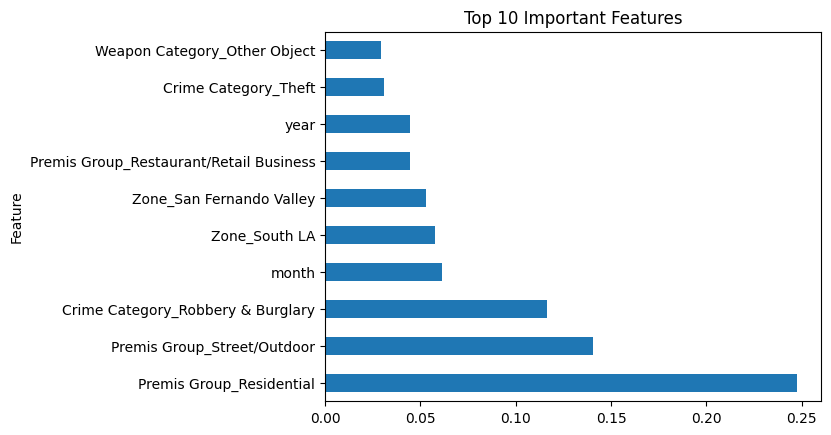

In [12]:
plt.figure(figsize=(10, 6))
feature_importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Top 10 Important Features")
plt.show()

## Conclusion
The feature importance analysis reveals that location-based features (e.g., **Premis Group_Residential** and **Zones**) and crime-specific attributes (e.g., **Crime Category_Robbery & Burglary**) are the most influential factors in predicting arrests. Temporal trends also play a significant role, suggesting that a deeper exploration of seasonal and geographic patterns could yield actionable insights for law enforcement strategies.

# Permutation Importance Analysis

This section provides an analysis of **permutation importance**, which evaluates feature importance by measuring the decrease in model performance when the values of a feature are randomly shuffled. This approach provides an alternative to feature importance based on tree splits, offering a more robust perspective on how each feature contributes to the model's predictions.

---
## Observations
1. **Premis Group_Residential**:
   - This feature remains the most critical, aligning with previous feature importance analyses. Its high importance reinforces the role of residential premises in predicting arrests.

2. **Crime Category_Robbery & Burglary**:
   - This feature has substantial importance, indicating that crimes of this type are pivotal in the model's decisions.

3. **Temporal Features**:
   - **Year** ranks as the third most important feature, showing that time-related patterns contribute significantly to arrest predictions.

4. **Geographic Trends**:
   - **Zone_San Fernando Valley** and **Zone_South LA** are key contributors, emphasizing the role of geographic regions in influencing arrest outcomes.

5. **Demographic and Crime-Specific Factors**:
   - **Victim Gender (Vict Sex_M)** and specific weapon categories, such as **Weapon Category_Knife**, are noteworthy contributors, highlighting demographic and situational details' impact on the predictions.

---



In [13]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_df.head(10))

                                  Feature  Importance
16               Premis Group_Residential    0.045947
7       Crime Category_Robbery & Burglary    0.021421
0                                    year    0.018750
4                Zone_San Fernando Valley    0.016848
11                             Vict Sex_M    0.006185
19                  Weapon Category_Knife    0.004569
5                           Zone_South LA    0.004420
18            Premis Group_Street/Outdoor    0.003994
10  Crime Category_Vandalism incl. Aarson    0.003065
8          Crime Category_Sexual Offenses    0.002460


## Conclusion
Permutation importance analysis confirms that features related to location (**Premis Group_Residential** and zones), crime type (**Crime Category_Robbery & Burglary**), and temporal patterns (**Year**) are the most influential in predicting arrest statuses. This aligns with earlier findings while adding robustness to the interpretation of feature relevance. Future work could explore how interactions between these features affect predictions to refine model insights further.

# SHAP Value Analysis for Feature Contribution

This section presents the results of **SHAP (SHapley Additive exPlanations)** value analysis, which provides interpretability for the machine learning model by explaining the impact of each feature on the predictions. SHAP values quantify how much each feature contributes positively or negatively to a particular prediction.

---

## Summary Plot of SHAP Values

The following summary plot visualizes the SHAP values for the top features in the dataset:

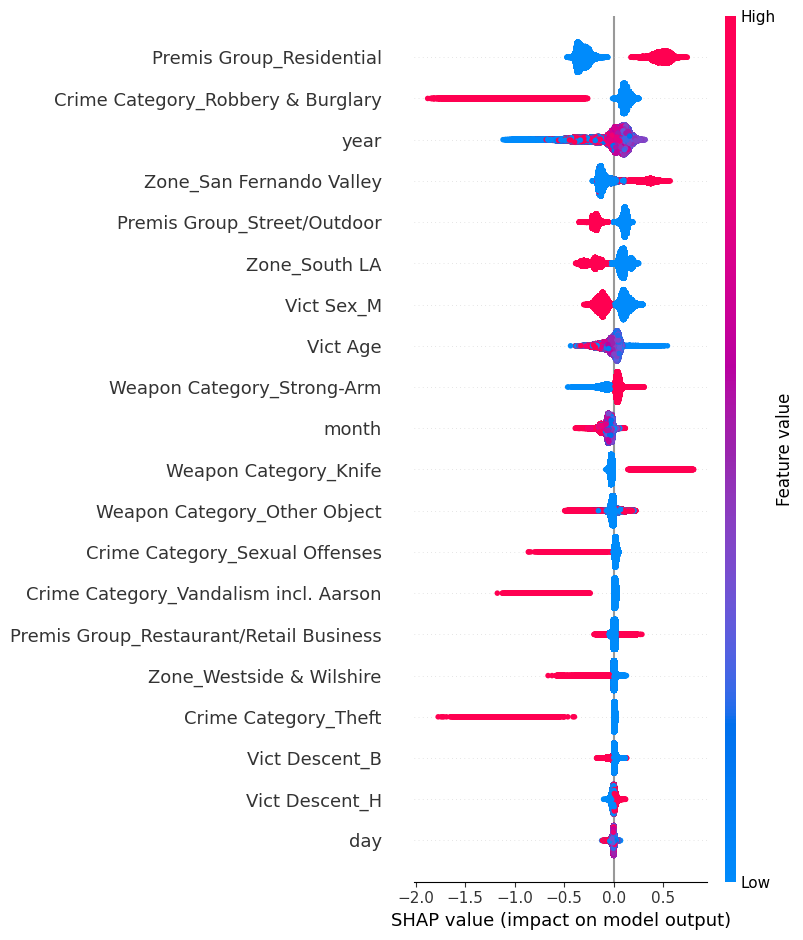

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### Key Features and Their Contributions
- **Premis Group_Residential**:
  - This feature has the highest impact on predictions. High values correspond to positive contributions toward predicting arrests, highlighting the role of residential premises in influencing outcomes.
  
- **Crime Category_Robbery & Burglary**:
  - Another highly impactful feature, indicating that specific types of crimes significantly affect the likelihood of arrests.

- **Year**:
  - Temporal trends are critical in the model, with higher years (recent data) having a notable influence.

- **Zone_San Fernando Valley** and **Zone_South LA**:
  - These geographic zones are influential, showing regional differences in crime patterns and arrest rates.

- **Victim Demographics (e.g., Vict Sex_M, Vict Age)**:
  - Gender and age of the victim also contribute significantly, providing demographic insights into crime and arrest trends.

- **Weapon Category_Knife and Weapon Category_Strong-Arm**:
  - The type of weapon used in a crime is a key driver, especially weapons like knives or strong-arm methods.

---

### Visual Interpretation
The summary plot:
1. Displays the SHAP values for each feature across all predictions.
2. Uses color to indicate the feature value (red for high values, blue for low values).
3. Highlights how different features influence the model's output, with features sorted by their overall impact.

For example:
- **Premis Group_Residential**: High feature values (red) increase the SHAP value, pushing predictions toward arrests.
- **Vict Sex_M**: Low feature values (blue) reduce the SHAP value, decreasing the likelihood of predicting arrests.

---

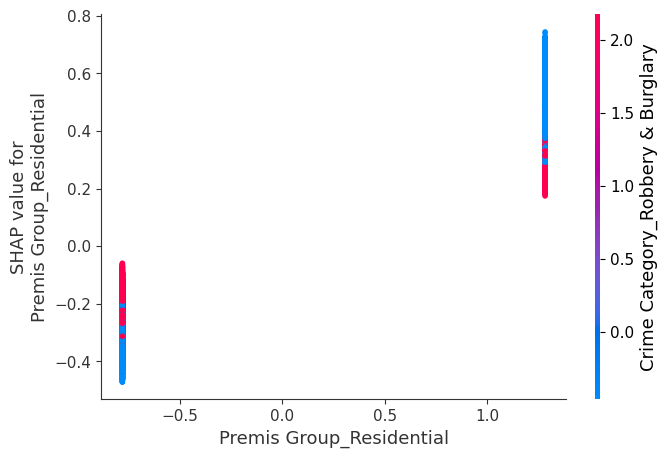

In [15]:
shap.dependence_plot("Premis Group_Residential", shap_values, X_test, feature_names=feature_names)

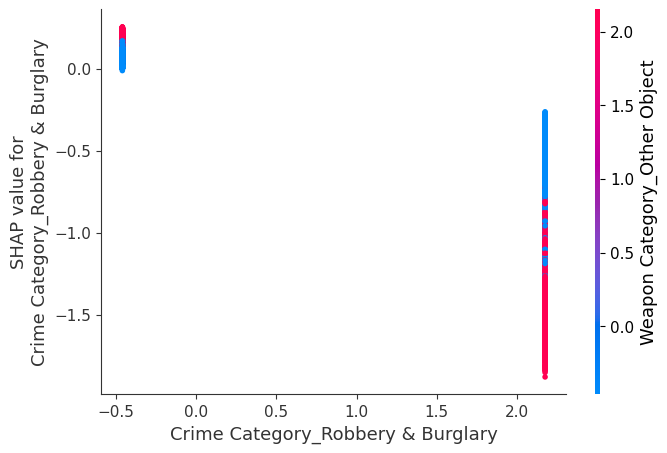

In [16]:
shap.dependence_plot("Crime Category_Robbery & Burglary", shap_values, X_test, feature_names=feature_names)


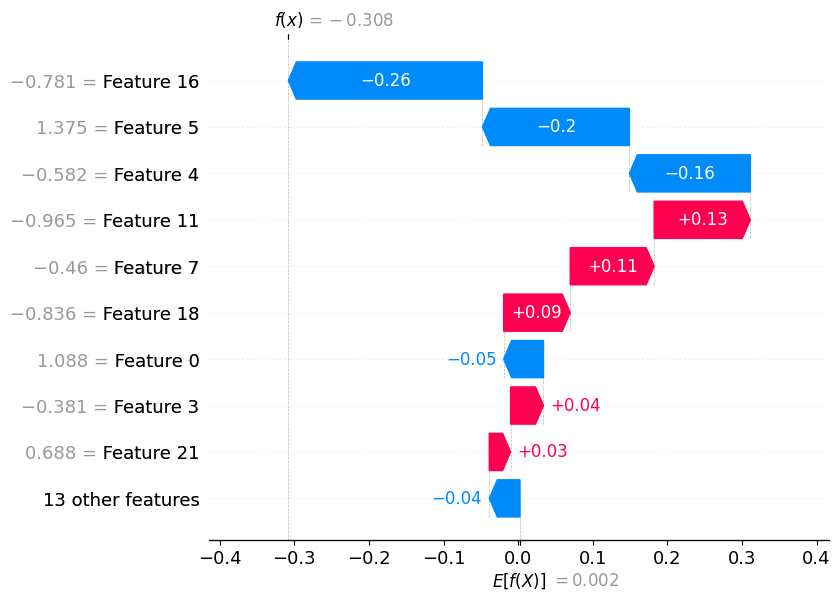

In [19]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer(X_test)  

shap.waterfall_plot(shap_values[0])


# Model Comparison: Evaluating Algorithms for Arrest Prediction

This section compares the performance of various machine learning algorithms tested on the dataset, including CatBoost, Logistic Regression, Gradient Boosting, and k-Nearest Neighbors (k-NN), alongside previously evaluated Random Forest and XGBoost models. The comparison highlights their strengths and weaknesses in predicting arrest statuses.

---

In [30]:
train_pool = Pool(X_train_res, y_train_res)
test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(
    iterations=350,
    depth=5,
    border_count=22,
    l2_leaf_reg=0.3,
    verbose=100  
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_test_pred = model.predict(test_pool)
y_test_prob = model.predict_proba(test_pool)[:, 1]

roc_auc_test = roc_auc_score(y_test, y_test_prob)
accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test ROC AUC score: {roc_auc_test:.4f}")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


0:	learn: 0.6890092	test: 0.6890348	best: 0.6890348 (0)	total: 50.7ms	remaining: 17.7s
100:	learn: 0.5958910	test: 0.6145881	best: 0.6145881 (100)	total: 3.82s	remaining: 9.41s
200:	learn: 0.5683794	test: 0.6053789	best: 0.6053789 (200)	total: 7.56s	remaining: 5.61s
300:	learn: 0.5545970	test: 0.6013192	best: 0.6013192 (300)	total: 11.3s	remaining: 1.83s
349:	learn: 0.5510708	test: 0.5999993	best: 0.5999993 (349)	total: 13s	remaining: 0us

bestTest = 0.5999992545
bestIteration = 349

Test ROC AUC score: 0.7309
Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.73     89540
           1       0.64      0.58      0.60     66814

    accuracy                           0.68    156354
   macro avg       0.67      0.67      0.67    156354
weighted avg       0.68      0.68      0.68    156354

Confusion Matrix:
[[67562 21978]
 [28351 38463]]


In [31]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)

lr_cv_scores = cross_val_score(lr_model, X_train_res, y_train_res, cv=5)
print(f"Logistic Regression Cross-validation scores: {lr_cv_scores}")
print(f"Mean Logistic Regression cross-validation score: {lr_cv_scores.mean():.2f}")

lr_model.fit(X_train_res, y_train_res)

y_test_pred = lr_model.predict(X_test)
y_test_prob = lr_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Logistic Regression Cross-validation scores: [0.65374414 0.65242247 0.6537836  0.65411865 0.65581483]
Mean Logistic Regression cross-validation score: 0.65
Accuracy: 0.66
ROC AUC score: 0.7057
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.69     89540
           1       0.59      0.65      0.62     66814

    accuracy                           0.66    156354
   macro avg       0.65      0.65      0.65    156354
weighted avg       0.66      0.66      0.66    156354

Confusion Matrix:
[[59303 30237]
 [23641 43173]]


In [32]:
gb_model = GradientBoostingClassifier(n_estimators=10, random_state=42)

gb_cv_scores = cross_val_score(gb_model, X_train_res, y_train_res, cv=5)
print(f"Gradient Boosting Cross-validation scores: {gb_cv_scores}")
print(f"Mean Gradient Boosting cross-validation score: {gb_cv_scores.mean():.2f}")

gb_model.fit(X_train_res, y_train_res)

y_test_pred = gb_model.predict(X_test)
y_test_prob = gb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Gradient Boosting Cross-validation scores: [0.65389072 0.65053782 0.65314841 0.65553562 0.65666641]
Mean Gradient Boosting cross-validation score: 0.65
Accuracy: 0.66
ROC AUC score: 0.7049
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     89540
           1       0.59      0.64      0.61     66814

    accuracy                           0.66    156354
   macro avg       0.65      0.65      0.65    156354
weighted avg       0.66      0.66      0.66    156354

Confusion Matrix:
[[60070 29470]
 [24298 42516]]


In [33]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_res, y_train_res)

y_test_pred_knn = knn.predict(X_test)
y_test_prob_knn = knn.predict_proba(X_test)[:, 1]

accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_test_prob_knn)

print(f"k-NN Accuracy: {accuracy_knn:.2f}")
print(f"k-NN ROC AUC Score: {roc_auc_knn:.4f}")
print("Classification Report for k-NN:\n", classification_report(y_test, y_test_pred_knn))
print("Confusion Matrix for k-NN:\n", confusion_matrix(y_test, y_test_pred_knn))

k-NN Accuracy: 0.62
k-NN ROC AUC Score: 0.6613
Classification Report for k-NN:
               precision    recall  f1-score   support

           0       0.69      0.63      0.66     89540
           1       0.55      0.61      0.58     66814

    accuracy                           0.62    156354
   macro avg       0.62      0.62      0.62    156354
weighted avg       0.63      0.62      0.62    156354

Confusion Matrix for k-NN:
 [[56276 33264]
 [25817 40997]]


## Results Summary

| Metric                 | Random Forest       | XGBoost            | Optimized XGBoost | CatBoost           | Logistic Regression | Gradient Boosting   | k-NN               |
|------------------------|---------------------|---------------------|-------------------|--------------------|---------------------|---------------------|---------------------|
| **ROC AUC Score**      | 0.7367             | 0.7341             | **0.7375**       | 0.7309            | 0.7057             | 0.7049             | 0.6613             |
| **Accuracy**           | 68%                | 68%                | 68%              | 68%               | 66%                | 66%                | 62%                |
| **Class 0 Precision**  | **72%**            | 71%                | 71%              | 70%               | 71%                | 71%                | 69%                |
| **Class 0 Recall**     | 71%                | 75%                | **76%**          | 75%               | 66%                | 67%                | 63%                |
| **Class 1 Precision**  | 62%                | 63%                | **64%**          | **64%**           | 59%                | 59%                | 55%                |
| **Class 1 Recall**     | **63%**            | 59%                | 57%              | 58%               | **65%**            | 64%                | 61%                |
| **Class 1 F1-Score**   | **63%**            | 61%                | 61%              | 61%               | 62%                | 61%                | 58%                |

---

## Key Observations

### Overall Performance
- The **Optimized XGBoost** model achieved the highest ROC AUC score (0.7375), indicating the best overall separability between classes.
- Accuracy for most models ranged between 66% and 68%, with **k-NN** performing the worst at 62%.

### Class-Specific Insights
1. **Class 0 (No Arrest)**:
   - **Optimized XGBoost** had the highest recall (76%), correctly identifying most of the majority class instances.
   - **Random Forest** had the highest precision (72%), minimizing false positives for Class 0.

2. **Class 1 (Arrest)**:
   - **Logistic Regression** had the highest recall (65%), making it the most sensitive to identifying arrests.
   - **Optimized XGBoost** and **CatBoost** shared the best precision (64%), effectively minimizing false positives for Class 1.

### Efficiency
- **CatBoost** provided competitive performance (ROC AUC: 0.7309) while being efficient and requiring minimal parameter tuning compared to XGBoost and Random Forest.
- **Gradient Boosting** and **Logistic Regression** achieved moderate performance but required less computational complexity than tree-based methods.

### Trade-Offs
- **Random Forest** and **Optimized XGBoost** balance precision and recall well, making them suitable for balanced decision-making between false positives and false negatives.
- **Logistic Regression** is the best choice for recall on the minority class (arrests), making it useful in scenarios prioritizing sensitivity over precision.

---

## Conclusion
- For balanced performance: **Optimized XGBoost** is the top performer, offering the best overall metrics across both classes.
- For arrest-focused scenarios: **Logistic Regression** and **Random Forest** provide better recall for the minority class.
- For efficient training: **CatBoost** delivers strong performance with minimal tuning requirements.

Future work could explore ensemble techniques to combine the strengths of multiple models, such as stacking or blending, to achieve improved results.







### Recommendations for Model Improvement and Data Balancing

To enhance the machine learning model, improved feature engineering can be explored by combining geographic and temporal features or deriving new variables such as crime rate density and holiday indicators. Further hyperparameter tuning, particularly for XGBoost and CatBoost, can optimize performance, while ensemble techniques like stacking or boosting could integrate predictions from top-performing models. Testing deep learning architectures, such as TabNet or TabTransformer, may also help capture non-linear relationships in the data.

Addressing class imbalance earlier in the data preparation phase could involve applying SMOTE or ADASYN, as well as undersampling or stratified sampling to balance class proportions. Synthetic data generation using GANs or VAEs and data augmentation for categorical variables based on trends could also improve dataset representation. Additionally, reweighting class distributions or revisiting the encoding of target variables to combine similar outcomes would help mitigate bias toward the majority class. By integrating these strategies, the model's fairness and predictive accuracy are likely to improve significantly.
